## 3D GLCM Features for Benthiemer Sandstone

#### This is an example file which decribes how to import a stack of micro-CT data and calculate the GLCM statistical values for a selected Region of Interest (ROI)

The micro-CT files are in .nc files extension. To use the pyradiomics library, the .nc files need to be converted to .nrrd file format where nrrd stands for 'nearly raw raster data'. This can be done using ImageJ (or Fiji). Once this is done, you need to save the nrrd image file in pyradiomics/data with its label (also in nrrd file format). For the labelled image, '0' stands for background and '1' stands for ROI. Ensure that you set the path to the pyradiomics folder on your desktop.

#### Import all libraries

In [15]:
from __future__ import print_function
import os
import collections
import SimpleITK as sitk
import numpy as np
import six
import radiomics
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, getTestCase
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import nrrd
from pathlib import Path
import sys
import logging as logger
import time
import json
import os
import logging.config

In [16]:
pwd

'C:\\Users\\User\\Desktop\\WRR\\pyradiomics\\notebooks'

In [17]:
def getParentPath(root = 'pyradiomics'):
    "get path of this project so we can create relative paths"
    p = Path('.').absolute()
    if not root in p.parts:
        logger.error('cannot find {} in current directory tree'.format(root))
        return p
    while p.name != root:
        p = p.parent
    return p    

#### Import micro-CT images: Bentheimer sandstone

This Bentheimer sandstone was originally 16-bit micro-CT image with a resolution of 2.9 micro-meters and 2520 x 2520 pixels in the x-y direction. I created a nrrd stack of size 1000 x 1000 x 520 and then, re-quantized it to 8-bit. Both these operations were carried out using ImageJ.  

In [24]:
#Read the entire Benthiemer sandstone 
filename_ben = 'investigate_bent_8bit.nrrd'
image_1 = sitk.ReadImage('C:\\Users\\User\\Desktop\\WRR\\pyradiomics\\data\\investigate_bent_8bit.nrrd')

#### Automation of 3D GLCM Features

The labels are mask or files with the moving windows. These files are created in the loop and then used to overlay on the micro-CT image of bentheimer (imported above) to calculate 3D GLCM features for that window/mask. The labels or masks are 8-bit binary files with 0 and 255 values. '0' indicates background and '255' indicates masked region or the window for which the GLCM features muct be calculated. 

In [25]:
label_1 = sitk.ReadImage('C:\\Users\\User\\Desktop\\WRR\\pyradiomics\\notebooks\\rock_label_w_25_xloc_0_yloc_0.nrrd')
print(type(image_1))
print(type(label_1))

<class 'SimpleITK.SimpleITK.Image'>
<class 'SimpleITK.SimpleITK.Image'>


Text(0.5, 1.0, 'ROI #1')

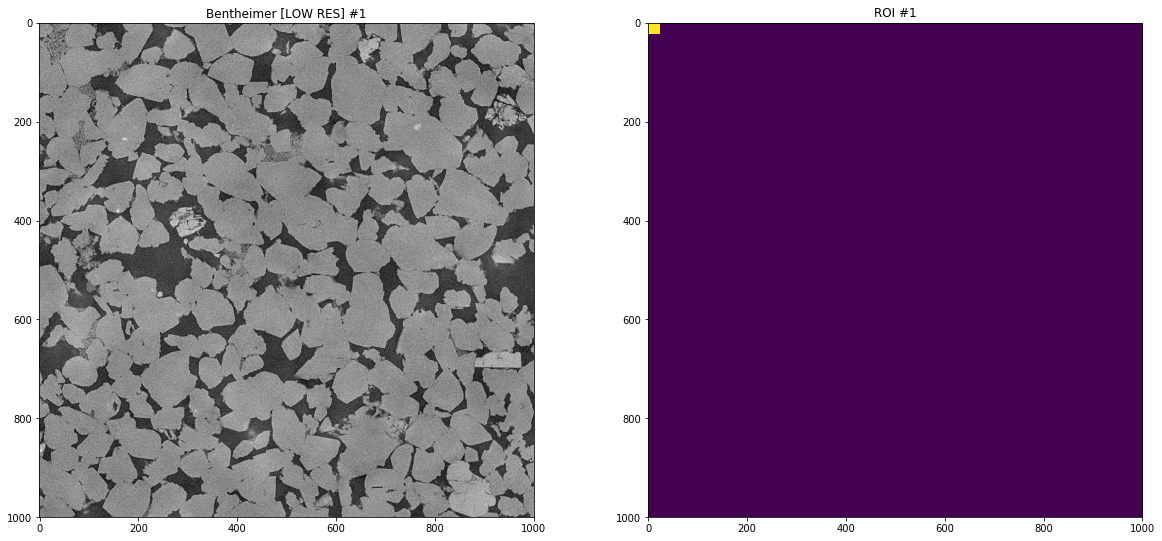

In [26]:
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[12,:,:], cmap="gray")
plt.title("Bentheimer [LOW RES] #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[12,:,:])        
plt.title("ROI #1")

In [27]:
z = 0
slice_ben = sitk.GetArrayViewFromImage(image_1)[z,:,:]
slice_ben.shape

(1000, 1000)

In [28]:
z = 0
ROI_ben = sitk.GetArrayViewFromImage(label_1)[z,:,:]

In [29]:
print(np.max(ROI_ben), np.min(ROI_ben))

255.0 0.0


In [31]:
ROI_ben.dtype

dtype('float64')

## Preprocess the image

#### Extraction Settings

In [11]:
settings = {}
settings['label'] = 255

In [12]:
settings

{'label': 255}

In [13]:
type(settings)

dict

## Calculate features using original image

In [14]:
# Crop the image
# bb is the bounding box, upon which the image and mask are cropped
bb, correctedMask = imageoperations.checkMask(image_1, label_1, label=255)

ValueError: Image/Mask datatype or size mismatch. Potential fix: enable correctMask, see Documentation:Usage:Customizing the Extraction:Settings:correctMask for more information

In [ ]:
correctedMask

In [16]:
if correctedMask is not None:
    print('1')
    label_1 = correctedMask
croppedImage, croppedMask = imageoperations.cropToTumorMask(image_1, label_1, bb)

In [17]:
bb

array([ 999, 1499,  999, 1499,    0,   39])

In [18]:
correctedMask

In [19]:
croppedImage

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000001C6AE1D8F00> >

In [20]:
croppedMask

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000001C6AE1D8A50> >

In [ ]:
z = 0
slice_croppedImage = sitk.GetArrayViewFromImage(croppedImage)[z,:,:]
slice_croppedImage.shape

Text(0.5, 1.0, 'ROI #1')

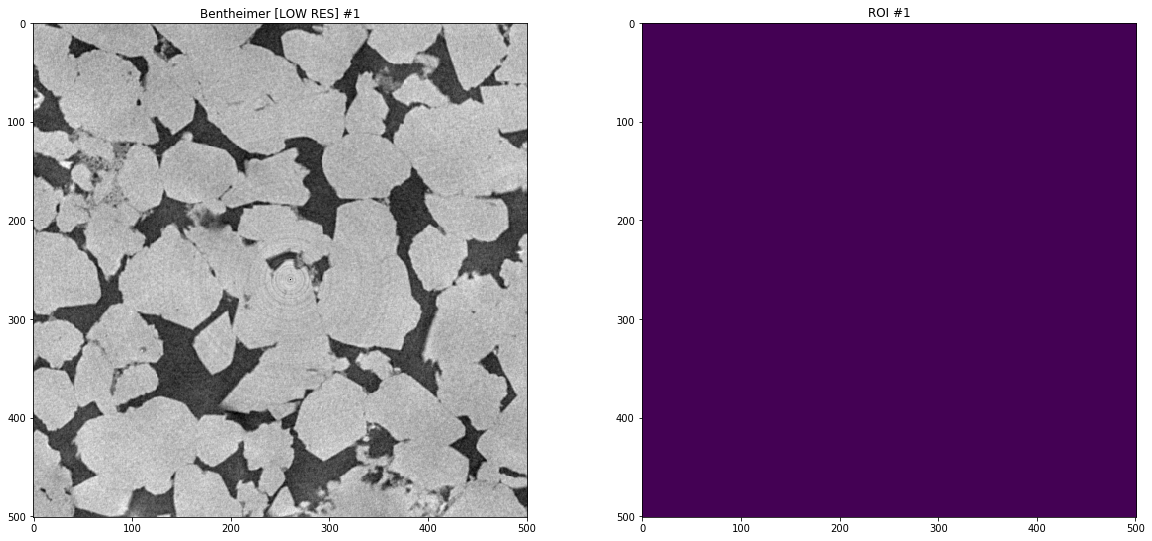

In [21]:
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(croppedImage)[12,:,:], cmap="gray")
plt.title("Bentheimer [LOW RES] #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(croppedMask)[12,:,:])        
plt.title("ROI #1")

### Calculate Firstorder features

In [22]:
firstOrderFeatures = firstorder.RadiomicsFirstOrder(croppedImage, croppedMask, **settings)

# Set the features to be calculated
firstOrderFeatures.enableFeatureByName('Mean', True)
# firstOrderFeatures.enableAllFeatures()

In [23]:
# Print out the docstrings of the enabled features
print('Will calculate the following first order features: ')
for f in firstOrderFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(firstOrderFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following first order features: 
Mean

    **8. Mean**

    .. math::
      \textit{mean} = \frac{1}{N_p}\displaystyle\sum^{N_p}_{i=1}{\textbf{X}(i)}

    The average gray level intensity within the ROI.
    


In [24]:
# Calculate the features and print(out result)
print('Calculating first order features...',)
result = firstOrderFeatures.execute()
print('done')

print('Calculated first order features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

Calculating first order features...
done
Calculated first order features: 
   Mean : 11130.7636649854


### Calculate GLCM Features

In [25]:
glcmFeatures = glcm.RadiomicsGLCM(croppedImage, croppedMask, **settings)

# Set the features to be calculated
#glcmFeatures.enableFeatureByName('SumEntropy', True)
glcmFeatures.enableAllFeatures()

In [26]:
# Print out the docstrings of the enabled features
print('Will calculate the following GLCM features: ')
for f in glcmFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(glcmFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following GLCM features: 
Autocorrelation

    **1. Autocorrelation**

    .. math::
      \textit{autocorrelation} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}{p(i,j)ij}

    Autocorrelation is a measure of the magnitude of the fineness and coarseness of texture.
    
ClusterProminence

    **3. Cluster Prominence**

    .. math::
      \textit{cluster prominence} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}
      {\big( i+j-\mu_x-\mu_y\big)^4p(i,j)}

    Cluster Prominence is a measure of the skewness and asymmetry of the GLCM. A higher values implies more asymmetry
    about the mean while a lower value indicates a peak near the mean value and less variation about the mean.
    
ClusterShade

    **4. Cluster Shade**

    .. math::
      \textit{cluster shade} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}
      {\big(i+j-\mu_x-\mu_y\big)^3p(i,j)}

    Cluster Shade is a measure of the skewness and uniformity of the GL

In [27]:
# Calculate the features and print(out result)
print('Calculating GLCM features...',)
result = glcmFeatures.execute()
print('done')

print('Calculated GLCM features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

Calculating GLCM features...


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


done
Calculated GLCM features: 
   Autocorrelation : 5630.661789159712
   ClusterProminence : 6573143.082053134
   ClusterShade : -70206.80421293683
   ClusterTendency : 1405.8633929621499
   Contrast : 53.380465658308
   Correlation : 0.9268378755695715
   DifferenceAverage : 4.602012231548359
   DifferenceEntropy : 3.667106427906363
   DifferenceVariance : 31.847993519372157
   Id : 0.32523514985122104
   Idm : 0.2364527940366443
   Idmn : 0.9992351868860455
   Idn : 0.9832167356200124
   Imc1 : -0.19344986225165103
   Imc2 : 0.9326526428933187
   InverseVariance : 0.24355932842978795
   JointAverage : 72.74985252024925
   JointEnergy : 0.002496737798464719
   JointEntropy : 9.740716661581144
   MCC : 0.9378725172640495
   MaximumProbability : 0.006585266523715572
   SumAverage : 145.4997050404982
   SumEntropy : 6.309019986784536
   SumSquares : 364.8109646551157
